In [6]:
# Notebook configuration

RESULTS_DIR = "./results"

In [104]:
# Python imports

import os
import json

import pandas as pd
from matplotlib import pyplot

In [105]:
# Accumulate results jsons
jsons = []

# locate a .json files in the results data dir
for root, dir, files in os.walk(RESULTS_DIR):
    for file in files:
        if file.endswith(".json"):
            fpath = os.path.join(root, file)
            jsons.append(fpath)

print(jsons)

['./results/h5py/fractals-1/jbenson/weaviate_benchmark__deep-image-96-angular.hdf5__128__32.json', './results/h5py/fractals-1/jbenson/weaviate_benchmark__deep-20M.hdf5__64__16.json', './results/h5py/fractals-1/jbenson/weaviate_benchmark__deep-image-96-angular.hdf5__64__32.json', './results/h5py/fractals-1/jbenson/weaviate_benchmark__deep-image-96-angular.hdf5__128__16.json', './results/h5py/fractals-1/jbenson/weaviate_benchmark__deep-image-96-angular.hdf5__64__16.json', './results/h5py/sv7-apu12/sho/weaviate_benchmark__gist-960-euclidean.hdf5__128__16.json', './results/h5py/sv7-apu12/sho/weaviate_benchmark__gist-960-euclidean.hdf5__64__16.json', './results/h5py/sv7-apu12/sho/weaviate_benchmark__gist-960-euclidean.hdf5__128__32.json', './results/h5py/sv7-apu12/sho/weaviate_benchmark__gist-960-euclidean.hdf5__64__32.json', './results/h5py/sv7-apu11/gwilliams/weaviate_benchmark__deep-2M.hdf5__128__32.json', './results/h5py/sv7-apu11/gwilliams/weaviate_benchmark__deep-1M.hdf5__128__32.json

In [106]:
# Load into one dataframe

rows = []

for jsonfile in jsons:
    f = open(jsonfile)
    objs = json.load(f)
    f.close()

    for obj in objs:
        row = {}
        row['benchmarkFile'] = obj['benchmarkFile']
        row['distanceMetric'] = obj['distanceMetric']
        row['totalTested'] = obj['totalTested']
        row['ef'] = obj['ef']
        row['efConstruction'] = obj['efConstruction']
        row['recall_10'] = obj['recall']['10']['average']
        row['latency_mean'] = obj['requestTimes']['limit_10']['latencies']['mean']
        row['latency_p90'] = obj['requestTimes']['limit_10']['latencies']['p90']
        row['latency_p95'] = obj['requestTimes']['limit_10']['latencies']['p95']
        row['latency_p99'] = obj['requestTimes']['limit_10']['latencies']['p99']
        
        row['totalDatasetSize'] = obj['totalDatasetSize']
        row['importTime'] = obj['importTime']

        rows.append(row)

df = pd.DataFrame(rows)
print(df)
        

                 benchmarkFile distanceMetric  totalTested   ef  \
0   deep-image-96-angular.hdf5         cosine        10000   64   
1   deep-image-96-angular.hdf5         cosine        10000  128   
2   deep-image-96-angular.hdf5         cosine        10000  256   
3   deep-image-96-angular.hdf5         cosine        10000  512   
4                deep-20M.hdf5         cosine         1000   64   
..                         ...            ...          ...  ...   
95                deep-5M.hdf5         cosine         1000  512   
96                deep-2M.hdf5         cosine         1000   64   
97                deep-2M.hdf5         cosine         1000  128   
98                deep-2M.hdf5         cosine         1000  256   
99                deep-2M.hdf5         cosine         1000  512   

    efConstruction  recall_10  latency_mean  latency_p90  latency_p95  \
0              128     9.6482      11183967     19270845     22993911   
1              128     9.7434      11642302     1

In [107]:
# Augment with various columns

def get_dset(row):
    if row['benchmarkFile'].find('deep')>=0:
        return 'Deep-1B'
    else:
        return "Unknown"

df['dataset'] = df.apply( lambda row: get_dset(row), axis=1 )

print(df)
        

                 benchmarkFile distanceMetric  totalTested   ef  \
0   deep-image-96-angular.hdf5         cosine        10000   64   
1   deep-image-96-angular.hdf5         cosine        10000  128   
2   deep-image-96-angular.hdf5         cosine        10000  256   
3   deep-image-96-angular.hdf5         cosine        10000  512   
4                deep-20M.hdf5         cosine         1000   64   
..                         ...            ...          ...  ...   
95                deep-5M.hdf5         cosine         1000  512   
96                deep-2M.hdf5         cosine         1000   64   
97                deep-2M.hdf5         cosine         1000  128   
98                deep-2M.hdf5         cosine         1000  256   
99                deep-2M.hdf5         cosine         1000  512   

    efConstruction  recall_10  latency_mean  latency_p90  latency_p95  \
0              128     9.6482      11183967     19270845     22993911   
1              128     9.7434      11642302     1

[10000, 1000000, 2000000, 5000000, 9990000, 20000000] [0.000625, 0.08347222222222223, 0.16833333333333333, 0.46034722222222224, 1.1159722222222221, 2.4630555555555556]


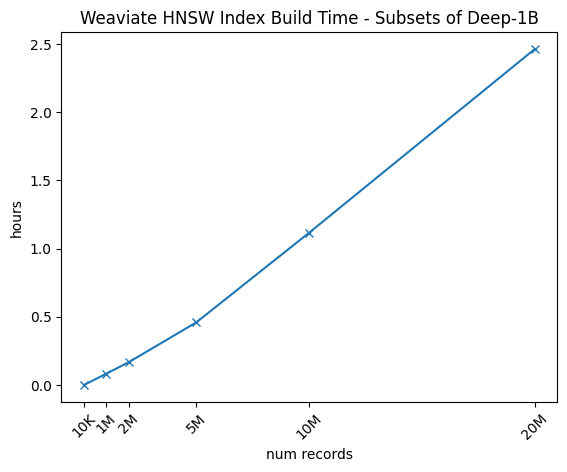

In [132]:
# Visualize import time for Deep-1B subsets

# compute average import time via groupby
df_import_time = df [ df['dataset']=='Deep-1B' ] \
    [ ['dataset', 'totalDatasetSize', 'importTime' ] ]
avg_import_time = \
    df_import_time.groupby( [ 'dataset', 'totalDatasetSize' ] )\
        ['importTime'].mean()

# get the plot points
xs = []
ys = []
for idx in avg_import_time.index:
    x = idx[1]
    xs.append(x)
    y = avg_import_time[idx]/(60.0*60.0)
    ys.append(y)
print(xs,ys)

# plot the lines and label the plot
fig, ax = pyplot.subplots()
ax.plot(xs,ys, marker='x')
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)
ax.set_xticklabels(['10K','1M','2M','5M','10M','20M'], rotation = 45)
ax.set_title("Weaviate HNSW Index Build Time - Subsets of Deep-1B")
fig.savefig("results/weaviate_hnsw_build_time.png")

Index(['benchmarkFile', 'distanceMetric', 'totalTested', 'ef',
       'efConstruction', 'recall_10', 'latency_mean', 'latency_p90',
       'latency_p95', 'latency_p99', 'totalDatasetSize', 'importTime',
       'dataset'],
      dtype='object')
[ 9990000 20000000  2000000  1000000  5000000    10000]
    dataset  totalDatasetSize  ef  efConstruction  recall_10  latency_mean
4   Deep-1B          20000000  64              64     9.0690       7773298
8   Deep-1B           9990000  64              64     9.4041      10249666
16  Deep-1B           9990000  64              64     9.1692      11797989
48  Deep-1B           1000000  64              64     9.7110       3236008
52  Deep-1B             10000  64              64     9.9790       2840174
56  Deep-1B           5000000  64              64     9.3060       3954395
64  Deep-1B           2000000  64              64     9.6330       3702162
80  Deep-1B           1000000  64              64     9.6170       3130610
84  Deep-1B             1

Text(0, 0.5, 'latency(ms)')

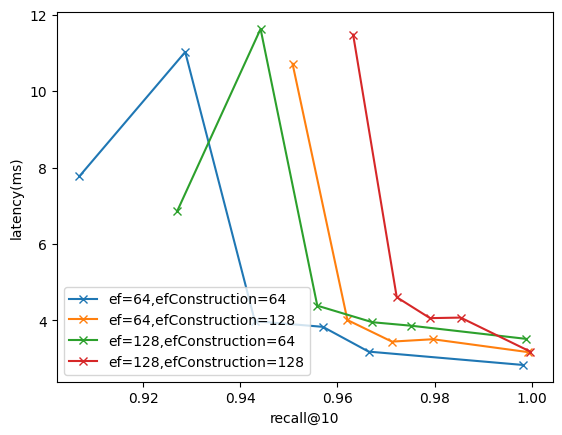

In [174]:
# Visualize the recall vs search latency for Deep-1B parameter groups

print(df.columns)

# get Deep-1B rows
df_recall_latency = df [ df['dataset']=='Deep-1B' ] \
    [ ['dataset', 'totalDatasetSize', 'ef', 'efConstruction', 'recall_10', 'latency_mean' ] ]

# get dataset sizes for Deep-1B so fara
dset_sizes = df[ df['dataset']=='Deep-1B' ]['totalDatasetSize'].unique()
print(dset_sizes)

# list the different parameter groups of interest
param_groups = [ (64,64), (64,128), (128,64), (128,128) ]

# extract plot points for each parameter group by dataset size
all_lines = {}
for pg in param_groups:
    # get df with those parameters
    _df = df_recall_latency[ \
        (df_recall_latency['ef']==pg[0]) &
        (df_recall_latency['efConstruction']==pg[1]) ]
    print(_df)
    # get the mean recall and latency
    recall_latency = _df.groupby(['totalDatasetSize']) \
        .mean(['recall_10','latency_mean'])
    
    recall = list(recall_latency['recall_10'])
    recall = [ rc/10.0 for rc in recall ]
    latency = list(recall_latency['latency_mean'])
    latency = [ lt/1000000.0 for lt in latency ]
    #print(recall, latency)

    all_lines[ pg ] = ( recall, latency )


# plot the lines and label the plot
fig, ax = pyplot.subplots()
for ln in all_lines.keys():
    xs = all_lines[ln][0]
    ys = all_lines[ln][1]
    ax.plot(xs,ys, marker='x',label="ef=%d,efConstruction=%d" % (ln[0],ln[1]))

ax.legend(loc='best')
ax.set_xlabel('recall@10')
ax.set_ylabel('latency(ms)')

ax.set_title("Weaviate HNSW Index Build Time - Subsets of Deep-1B")
fig.savefig("results/weaviate_hnsw_build_time.png")